**Fetch crypto prices from coin gecko**
- activate environment: conda activate base
- install pycoingecko: conda install -c conda-forge pycoingecko


In [110]:

from pycoingecko import CoinGeckoAPI
import pandas as pd
from datetime import datetime, timedelta
import time

#initialize coingecko api client

cg = CoinGeckoAPI()

#start date, end date
days= 180
end_date = datetime(2024, 10, 14)
start_date = end_date - timedelta(days=days)
end_timestamp = int(time.mktime(end_date.timetuple())) * 1000

#list of coins to compare 
coins = ['bitcoin', 'ethereum', 'tether', 'binancecoin']

#fetch historical price data for the last 180 days

price_data = {}
for coin in coins:
    try:
        data = cg.get_coin_market_chart_by_id(
            id=coin, 
            vs_currency='myr',
            days=days
        )
        prices = pd.DataFrame(data['prices'], columns=['Timestamp', 'Price'])
        prices['Timestamp'] = pd.to_datetime(prices['Timestamp'], unit='ms')
        prices = prices[(prices['Timestamp'] >= start_date) & (prices['Timestamp'] <= end_date)]
        prices['Coin'] = coin             #add column for coin name
        price_data[coin] = prices
        
    except Exception as e:
        print(f'failed to fetch data for {coin}: {e}')

# price_data['bitcoin'].head()

#combine all coin data into a single df
combined_price_data = pd.concat(price_data.values(), ignore_index=True)

#pivot df to have coins as columns
pivoted_coin = combined_price_data.pivot(index='Timestamp', columns='Coin', values='Price')

pivoted_coin.reset_index(inplace=True)

pivoted_coin = pivoted_coin.reindex(columns=['Timestamp'] + coins)

pivoted_coin.head()

# pivoted_coin.to_csv('crypto_price.csv')


Coin,Timestamp,bitcoin,ethereum,tether,binancecoin
0,2024-06-29,284545.905001,15919.699702,4.708682,2673.780798
1,2024-06-30,287128.010616,15904.005040,4.709792,2684.436667
2,2024-07-01,295949.502938,16206.114211,4.710452,2744.540520
3,2024-07-02,296069.822355,16203.336789,4.708437,2716.847546
4,2024-07-03,292704.413332,16124.961192,4.711511,2731.721551


In [111]:
pivoted_coin.columns

Index(['Timestamp', 'bitcoin', 'ethereum', 'tether', 'binancecoin'], dtype='object', name='Coin')

In [112]:
pivoted_coin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Timestamp    108 non-null    datetime64[ns]
 1   bitcoin      108 non-null    float64       
 2   ethereum     108 non-null    float64       
 3   tether       108 non-null    float64       
 4   binancecoin  108 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 4.3 KB


**Visualize crypo price for the past 180 days**

In [113]:
import plotly.express as px

melted_coin_data = pivoted_coin.melt(id_vars='Timestamp', value_vars=coins, var_name='Coin', value_name='Price')

fig = px.line(
    melted_coin_data, x='Timestamp', y='Price', color='Coin',
    title='Cryptocurrency Prices over 180 Days (14/4 - 14/10)',
    labels={'Price': 'Price(MYR)', 'Timestamp': 'Date'},
    template='plotly_dark',
    width=900, height=400
)

fig.show()

fig.write_html('../static/HTML/crypto_price_trend.html')

In [114]:
import plotly.express as px
import plotly.subplots as sp
import pandas as pd

# Melt the DataFrame to long format
melted_coin_data = pivoted_coin.melt(id_vars='Timestamp', value_vars=coins, var_name='Coin', value_name='Price')

# Create a figure with 2 rows and 2 columns
fig = sp.make_subplots(rows=2, cols=2, subplot_titles=coins)

# Plot each coin in the appropriate subplot
for i, coin in enumerate(coins):
    row = i // 2 + 1  # Determine row number (1-based index)
    col = i % 2 + 1   # Determine column number (1-based index)

    # Filter data for the current coin
    coin_data = melted_coin_data[melted_coin_data['Coin'] == coin]

    # Add a line trace for the current coin
    fig.add_trace(
        px.line(coin_data, x='Timestamp', y='Price', labels={'Price': 'Price (MYR)', 'Timestamp': 'Date'}).data[0],
        row=row, col=col
    )

# Update layout of the overall figure
fig.update_layout(
    title='Cryptocurrency Prices over 180 Days (14/4 - 14/10)',
    template='plotly_dark',
    height=800,  # Adjust height for better visibility if needed
    showlegend=False  # Disable the legend since titles are already present in subplots
)

fig.show()

# fig.write_html('./HTML/crypto_price_trend_subplots.html')

**Visualize sentiment score against price**

In [115]:
# price_data = pd.read_csv('crypto_price.csv')
sentiment_score = pd.read_csv('../data sources/crypto_sentiment_score.csv')

# print(pivoted_coin.head())
# print(sentiment_score.head())
# print(pivoted_coin.columns)
# print(sentiment_score.columns)
# # print(price_data.info())

# print(pivoted_coin['Timestamp'].isnull().sum())  # Check for missing values


**Correlation Analysis**


In [121]:
import plotly.graph_objs as go

# pivoted_coin['Timestamp'] = pd.to_datetime(pivoted_coin['Timestamp'])

correlation_matrix = pivoted_coin[['bitcoin', 'ethereum', 'tether', 'binancecoin']].corr()

fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix,
    x=correlation_matrix.columns,
    y=correlation_matrix.columns,
    colorscale=[[0, 'red'], [0.5, 'white'], [1, 'blue']]
))

fig.update_layout(
    title='Correlation Matrix', xaxis_title='Cryptocurrency', 
    yaxis_title='Cryptocurrency', template="plotly_dark",
    width=900, height=400
    )
fig.show()

fig.write_html('../static/HTML/correlations_analysis.html')

**Indicator**
- High positive correlation: close to 1 = they move together
- Moderate correlation: 0.5 to 0.8
- Low or No correlation = close to 0 = no relationship

**Analysis**
1) Bitcoin = Binancecoin (0.929) and ethereum (0.916) has strong positive correlation. btc moves up, those two would follow
    - Tether (0.763) has moderate correlation to bitcoin
    - USDT is a stablecoin, it might not experience the same volaitlity as btc

2) Ethereum = Bitcoin (0.916) has strong positive correlation
    - Against binancecoin (0.863) and tether (0.874), it has moderate correlation
    - ETH often moves in tandem with btc

3) tether = Ethereum (0.874), it has close to positive correlation
    - Against bitcoin (0.763) and binance(0.729 )they have moderate corelation
    - usdt (tether) can be affected by ETH's price movement but bcs it's pegged to US dollars, the price doenst flcutuate much

4) Binancecoin = bitcoin (0.929), it has strong positive correlation
    - ethereum (0.863), it's close to psotive correlation
    - tether (0.729), it has moderate correlation



**Volatility Analysis**

In [117]:
pivoted_coin['Timestamp'] = pd.to_datetime(pivoted_coin['Timestamp'])
pivoted_coin.set_index('Timestamp', inplace=True)


volatility = pivoted_coin[['bitcoin', 'ethereum', 'tether', 'binancecoin']].pct_change() 

fig = go.Figure()
for coin in ['bitcoin', 'ethereum', 'tether', 'binancecoin']:
    fig.add_trace(go.Scatter(x=volatility.index, y=volatility[coin], mode='lines', name=coin))
    
fig.update_layout(
    title='Cryptocurrency Daily Volatility over 180 Days (14/4 - 14/10)',
    xaxis_title='Date', 
    yaxis_title='Volatility (Daily percentage change)',
    width=900,
    height=400,
    legend=dict(
        x=1,
        y=0,
        xanchor='right',
        yanchor='bottom'
    ),
    template="plotly_dark" 
)
fig.show()

fig.write_html('../static/HTML/volatility_analysis.html')

**Volatility Analysis**
- tether is very stable with less volatility due to being pegged to us dollar
- id 52, on 9/6, when the price of other coins crashed, usdt price increased as traders might flock to stablecoin which leads to increase demand for it
- price for btc, eth, bnb dropped the most on 4/8 (Look for reasons behind crash)
- Generally, eth experienced the worst drop and best jump when price fluctuates followed by bnb (exclude stablecoin + btc)

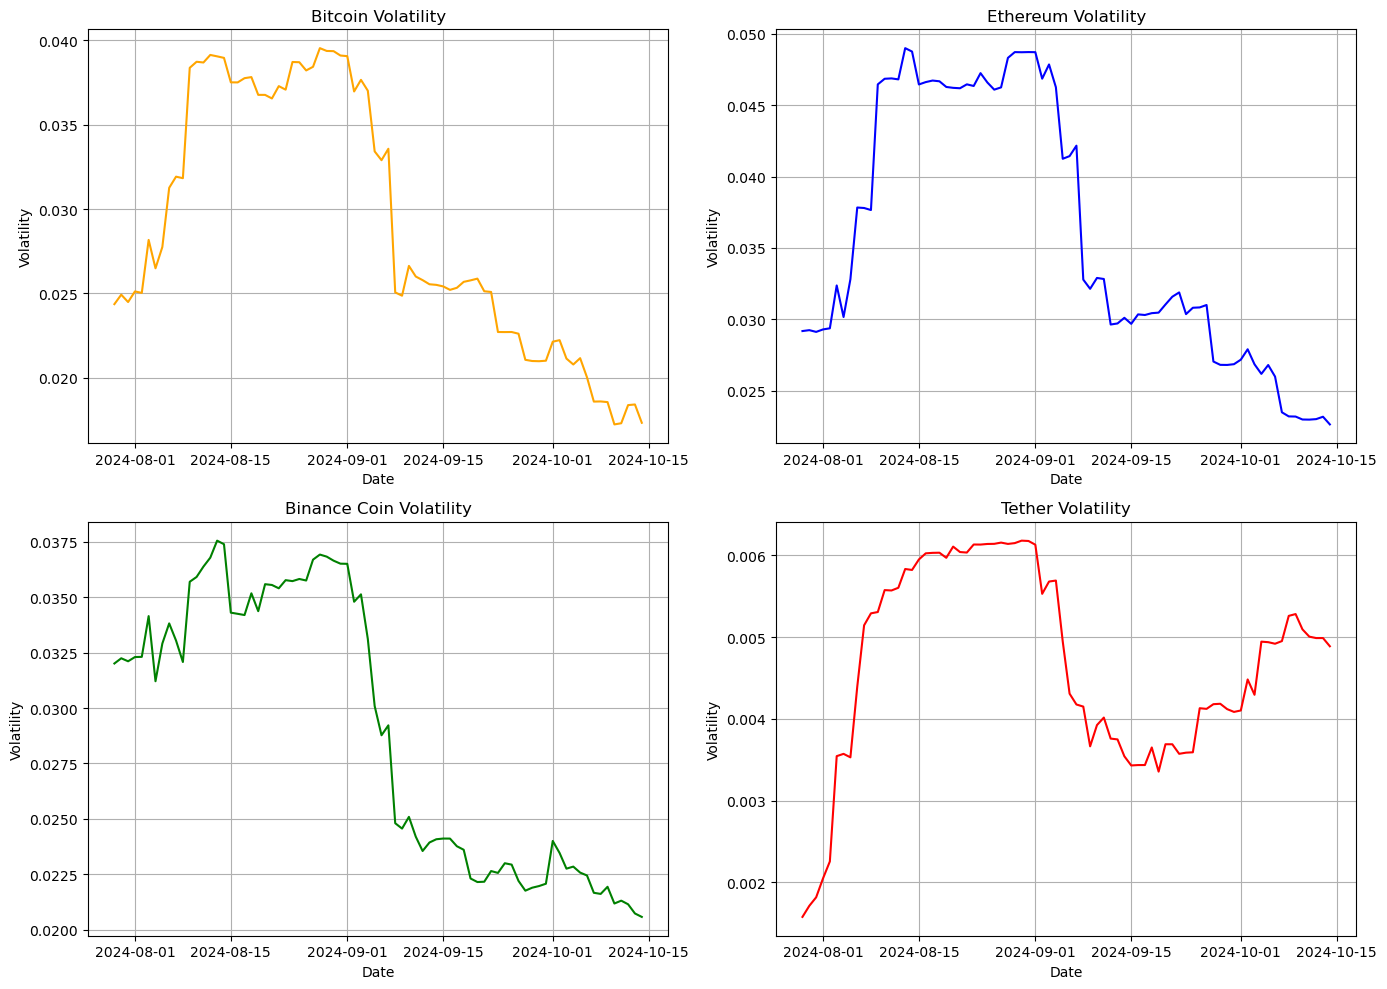

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate daily returns
returns = pivoted_coin.pct_change()

# Calculate volatility (standard deviation of returns)
window = 30  # Rolling window for volatility
volatility = returns.rolling(window).std()

# Plotting
plt.figure(figsize=(14, 10))

# Plot each coin's volatility
plt.subplot(2, 2, 1)
plt.plot(volatility.index, volatility['bitcoin'], label='Bitcoin', color='orange')
plt.title('Bitcoin Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(volatility.index, volatility['ethereum'], label='Ethereum', color='blue')
plt.title('Ethereum Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(volatility.index, volatility['binancecoin'], label='Binance Coin', color='green')
plt.title('Binance Coin Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(volatility.index, volatility['tether'], label='Tether', color='red')
plt.title('Tether Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid()

plt.tight_layout()
plt.show()



**Return Analysis**
- it evaluates how much profit or loss an investment generates over a specific period

In [119]:
#calculate daily returns and cumulative returns
returns = pivoted_coin.pct_change()
cumulative_returns = (1 + returns).cumprod()

fig = go.Figure()

for coin in ['bitcoin', 'ethereum', 'tether', 'binancecoin']:
    fig.add_trace(go.Scatter(
        x=cumulative_returns.index,
        y=cumulative_returns[coin], mode='lines', name=coin
    ))

fig.update_layout(title='Cumulative Returns of Cryptocurrencies', xaxis_title='Date', yaxis_title='Cumulative Returns')
fig.show()

**Cumulative Return Analysis**
- Indicator
    1) if the return is more than 1, it means the ivestment has increased (i.e. 1.2, investment increased by 20%)
    2) if the return is less than 1, it indicates a loss (0.5 means the investment worth 50% of the initial amont invested)

**Return analysis (percentage)**

In [120]:
#calculate daily returns and cumulative returns
returns = pivoted_coin.pct_change()
cumulative_returns = (1 + returns).cumprod() - 1
cumulative_returns_percent = cumulative_returns * 100

fig = go.Figure()

for coin in ['bitcoin', 'ethereum', 'tether', 'binancecoin']:
    fig.add_trace(go.Scatter(
        x=cumulative_returns_percent.index,
        y=cumulative_returns_percent[coin], mode='lines', name=coin
    ))

fig.update_layout(
    title='Daily Cumulative Returns of Cryptocurrencies (Percentage) over 180 Days (14/4 - 14/10)', 
    xaxis_title='Date', yaxis_title='Cumulative Returns (%)', 
    template="plotly_dark", width=900, height=400)

fig.show()

fig.write_html('../static//HTML/daily_returns_analysis.html')

**Return Analysis (Percentage)**
- 0%: no change in value
- 20%: investment has increased by 20%
- -50%: a loss of 50% of investment

**Analysis**
1) Ethereum
    - return for Eth peaked slighly at the end of April, then crashed below 0% until 20/5
    - It peaked significantly on 23/5 then started to gradually decline on early June until end of June beofre crashing to -28% around first week of August
    - it was gradually increasing within August, still below -15% before decline even more on early september to -34%
    - the price was volatile until mid october (below -20%)

2) Binance coin
    - it mirors ethereum's volaitlity but performed slighly better from end of April until 20/5, range from 0 to 10%
    - return for bnb was the highest on 7/6 (25%), then dropped significantly a week after, the decline mirrors eth but bnb performed little worse lol
    - it performed better than eth on early augsut until mid october, price was volatile and the loss being slighlty less than 0%

3) Bitcoin
    - the return dropped to -10% on early May
    - it gradually increased to 10% on 21/5
    - the returns were volatile for a month (still above 0) but gradually crashed to blow 0 until 9/7
    - it gradually increased until the returns maintained at around 5% for two weeks before it declined to -20%
    - from august to october, the returns were volatile and loss percentages are below -10%
    - it performed better than Ethereum but binance coin outperformed it around this period

4) USDT
    - The cumulative return for tether is gradually decreasing but not as steep as the ohter 3 coins. 
    - from May to August, the returns maintain slightly below 0, starting August, it declined in the range of -5% until -10% on mid september
    - but it slowly jumps back to -9% on mid October
